In [1]:
import numpy as np
import xarray as xr
# import itertools
import matplotlib.pyplot as plt
# from cartopy import geodesic
# import cartopy.crs as ccrs
# import shapely
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import draft_functions as funk
import cmocean.cm as cmo

from matplotlib.gridspec import GridSpec


In [2]:
initial_depth = 4835

lon_sample = -3.822
lat_sample = -29.992

origin = (lon_sample, lat_sample)

start_time = datetime.strptime('2019-01-16 12:00:00', '%Y-%m-%d %H:%M:%S')
sim_time = 4480
# create the date range in reverse from sampling time to the past
datelist = pd.date_range(end=start_time, periods=sim_time)[::-1]
end_time = datelist[0]

depth_bins = np.linspace(-5500, 0, 56)  # creates a 100m bins

simulations = [0, 1000]
sim_names = [0, 1000]

# labbb = [r'with $K_z$', r'No $K_z$']

In [3]:
# %% Extracting the data from simulation outputs
frag_into_NPs = {}


for k, ft in enumerate(tqdm(simulations)):
    # print('Computing fragmentation timescale: ', ft)
    local_path = f'/storage/shared/oceanparcels/output_data/data_Claudio/hc11/hc11_{ft}.zarr'
    sim = xr.open_zarr(local_path)
    nano = sim.where(sim.radius < 1e-6/2, drop=False)
    sim_dict = {}
    print(local_path)
    
    # Find indices of the particles that are not NaN
    aux = np.isnan(nano['radius'].values)
    traj = nano.trajectory.values
    index_MP = np.sum(aux, axis=1)
    index_NP = len(nano.obs) - 1 - np.sum(aux, axis=1)
    sim_dict['particle_index'] = index_NP
    
    # Get depth, latitude, and longitude of NPs
    z = -nano['z'].values
    sim_dict['depths'] = z[(traj, index_NP)]

    latNP = nano['lat'].values
    lonNP = nano['lon'].values

    sim_dict['lat'] = latNP[(traj, index_NP)]
    sim_dict['lon'] = lonNP[(traj, index_NP)]
    sim_dict['time'] = nano['time'].values[(traj, index_NP)]
    sim_dict['radius'] = nano['radius'].values[(traj, index_NP)]
    sim_dict['frag_events'] = nano['frag_events'].values[(traj, index_NP)]

    # Compute displacement of NPs from a reference point (origin)
    xy_pos = (lonNP[(traj, index_NP)], latNP[(traj, index_NP)])
    sim_dict['displacement'] = funk.haversine(origin, xy_pos)

    # Compute histograms of particle counts for each depth bin over time
    zbins = len(depth_bins)-1
    hist_counts = np.zeros((zbins, sim_time))
    t_range = range(0, sim_time, 1)
    
    
    for i, fr in enumerate(tqdm(t_range)):
        x = np.histogram(-nano['z'][:, fr].dropna('trajectory'), bins=depth_bins,
                         density=False)
        hist_counts[:, i] = x[0]

    # Compute total number of particles in each time step
    total_particles = np.sum(hist_counts, axis=0)
    sim_dict['counts'] = total_particles

    p_zt = np.ma.masked_equal(hist_counts, 0) #/total_particles
    # creat a rolling average of h_masked

    sim_dict['vertical_distribution'] = p_zt

    frag_into_NPs[sim_names[k]] = sim_dict
    
    # np.save('../data/frag_diff_nodiff.npy', frag_into_NPs, allow_pickle=True)


  0%|          | 0/2 [00:00<?, ?it/s]

/storage/shared/oceanparcels/output_data/data_Claudio/hc11/hc11_0.zarr


 50%|█████     | 1/2 [05:38<05:38, 338.92s/it]

/storage/shared/oceanparcels/output_data/data_Claudio/hc11/hc11_1000.zarr


100%|██████████| 2/2 [10:41<00:00, 320.74s/it]


In [11]:
sim_names[0]

0

/tmp/ipykernel_679989/2348467361.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[j].pcolormesh(x, y, frag_into_NPs[ft]['vertical_distribution'],


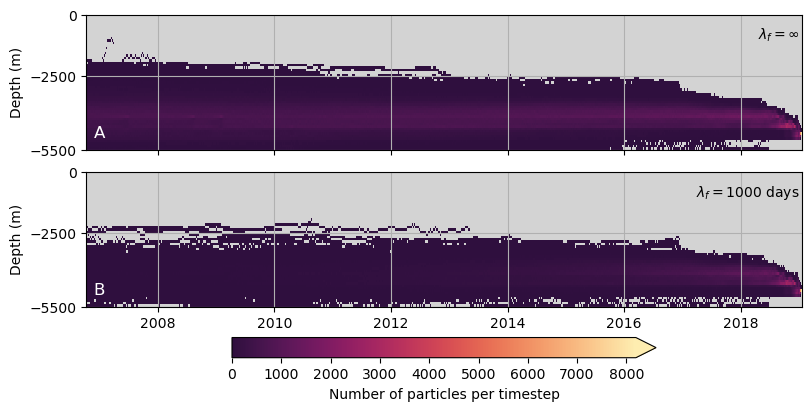

<Figure size 640x480 with 0 Axes>

In [14]:
x, y = np.meshgrid(datelist, depth_bins)

fig, ax = plt.subplots(ncols=1, nrows=len(simulations), figsize=(8, 4),
                       sharex=True, constrained_layout=True)

color_map = cmo.matter_r

for j, ft in enumerate(sim_names):
    ax[j].set_facecolor('lightgrey')
    im = ax[j].pcolormesh(x, y, frag_into_NPs[ft]['vertical_distribution'],
                          cmap=color_map,
                          vmin=0)
    
    ax[j].set_yticks([-5500, -2500, 0])
    ax[j].grid()

ax[0].set_ylabel('Depth (m)')
ax[0].text(17900, -1000, r'$\lambda_f = \infty$', fontsize=10,
               ha='right')
ax[1].set_ylabel('Depth (m)')
ax[1].text(17900, -1000, r'$\lambda_f = 1000$ days', fontsize=10,
               ha='right')

ax[0].text(13550, -5000, r'A', fontsize=12,
               ha='right', c='w')

ax[1].text(13550, -5000, r'B', fontsize=12,
               ha='right', c='w')


fig.colorbar(im, ax=ax[-1], orientation='horizontal',
             extend='max', label='Number of particles per timestep')

# ax[0].set_title('Nanoparticles (50-1000 $nm$) in the water column')
plt.show()
plt.savefig('../article_figs/HC11_colloidal.png', dpi=300, bbox_inches='tight')


In [7]:
surface_events = {}


for k, ft in enumerate(tqdm(simulations)):
    # print('Computing fragmentation timescale: ', ft)
    local_path = f'/storage/shared/oceanparcels/output_data/data_Claudio/hc11/hc11_{ft}.zarr'
    sim = xr.open_zarr(local_path)

    # loading fields as np arrays to do some nasty indexing
    radiuses = sim['radius'].values
    depths = sim['z'].values
    latitudes = sim['lat'].values
    longitudes = sim['lon'].values
    frag_events = sim['frag_events'].values

    df_sim = {}  # dictiorany to store data per sim. Could be a pandas DF

    # Detecting the index and the particles that reach the surface
    k1, k2 = np.where(depths < 10)
    idx_particles, idx_k2 = np.unique(k1, return_index=True)
    surface_time = k2[idx_k2]
    
    m1, m2 = np.where(radiuses > 1e-4)
    _, idx_m2 = np.unique(m1, return_index=True)
    time_fragmetation = m2[idx_m2]

    df_sim['particle_index'] = idx_particles
    df_sim['surface_time'] = surface_time  # Days. equivalent to index in simus
    df_sim['radius'] = radiuses[idx_particles, surface_time]
    df_sim['depths'] = depths[idx_particles, surface_time]
    df_sim['frag_events'] = frag_events[idx_particles, surface_time]
    df_sim['frag_time'] = time_fragmetation

    latz = latitudes[idx_particles, surface_time]
    lonz = longitudes[idx_particles, surface_time]
    xy_pos = (lonz, latz)

    df_sim['displacement'] = funk.haversine(origin, xy_pos)
    df_sim['lat'] = latz
    df_sim['lon'] = lonz

    surface_events[sim_names[k]] = df_sim  # Storing the dictionaris in another dict


# np.save('../data/surface_events_k2k3k4.npy', surface_events)

100%|██████████| 2/2 [00:02<00:00,  1.13s/it]
